<div style="text-align: left;">
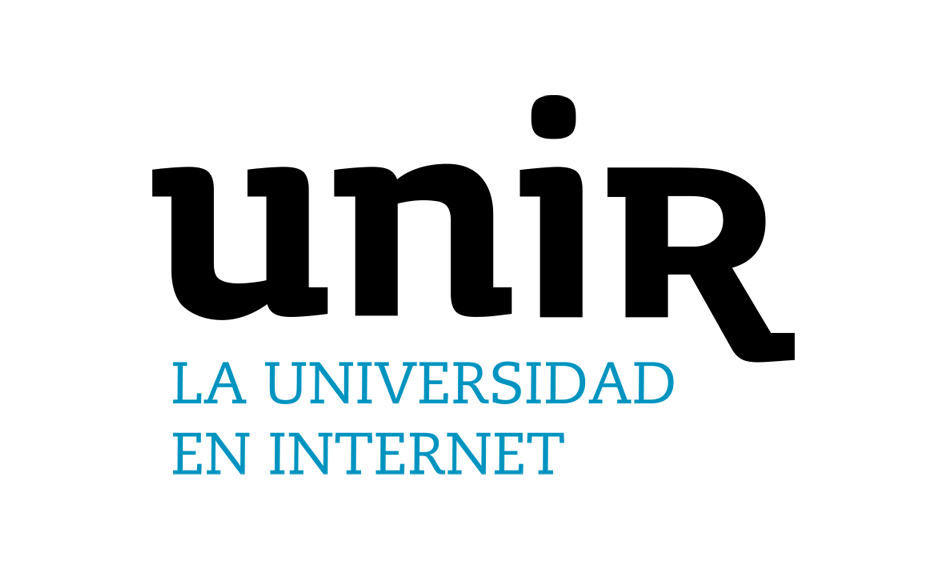
     <div>
        <h1>Actividad: Estimación de parámetros de un activo financiero.</h1>
        <p>Autor: Gonzalo Miguel Gómez del Hierro</p>
        <p>Prof: Dr. Miguel Angel Navarro Burgos</p>
        <p>Máster Universitario en Ingeniería Matemática y Computación</p>
        <p>Modelización y Valoración de Derivados y Carteras en Finanzas</p>
    </div>
</div>

Para llevar a cabo el ejercicio tomo datos de cotización de Banco Santander entre el 30 de abril de 2024 y el 30 de octubre de 2024. Estas fechas están escogidas de manera que entre medias de la ventana temporal no se pagase ningún dividendo sobre la acción, pues el tratamiento de los dividendos es delicado. Los datos se han tomado de [https://www.investing.com/].

En la práctica se pide calibrar mediante datos históricos los parámetros de un modelo Log-Normal para la dinámica del subyacente. Estos parámetros son la deriva ($\mu$) y la difusión ($\sigma$) en la ecuación diferencial estocástica siguiente:
$$dS_t=\mu S_tdt + \sigma S_tdW_t$$
La anterior ecuación tiene solución explícita:
$$S_t=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W_t}$$
donde $W_t$ es un proceso de Wiener. Suponiendo que el activo modelado sigue la dinámica anterior, tenemos que:
$$U_i=ln\left(\frac{S_i}{S_{i-1}}\right)=\left(\mu-\frac{1}{2}\sigma^2\right)(t_i-t_{i-1})+\sigma (W_{t_i}-W_{t_{i-1}})$$
Y por tanto $U_i$ sigue una distribución normal de media $\left(\mu-\frac{1}{2}\sigma^2\right)(t_i-t_{i-1})$ y varianza $\sigma^2(t_i-t_{i-1})$.

A continuación, vamos a ajustar los parámetros de nuestro modelo a partir de datos históricos mediante el método de el método de momentos teóricos y el método de máxima verosimilitud, pues en la práctica se pide usar dos de los tres métodos desarrollados en el tema.

En lo consecuente, se va a realizar una aproximación, y es que se va a considerar que el paso entre 2 días de mercado consecutivos es nuestra unidad de tiempo, de manera que el factor $(t_i-t_{i-1})$ va a ser constante, pero ajustado de manera que en el total de pasos supongan el número de días naturales en la ventana, independientemente del tiempo real entre dos fechas de cotización (los findes y los festivos no hay cotización). Esta aproximación es razonable en el nivel de detalle deseado aquí, pero normalmente habría que tener en cuenta que la varianza acumulada a través de un finde no es la misma que la que esperaríamos entre el cierre y la apertura del mercado en días naturales consecutivos.

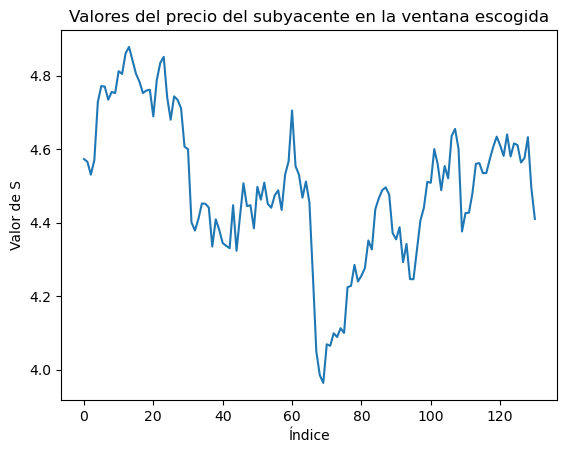

In [24]:
# cargamos los datos 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Leer el archivo CSV
S_reverse = pd.read_csv("SAN_Historical_Data.csv").iloc[:, 1].to_numpy() # últimos n datos
S = np.flip(S_reverse) #los datos vienen ordenados de más reciente a más antiguo
# Graficar los datos
plt.plot(S)
plt.title('Valores del precio del subyacente en la ventana escogida')
plt.xlabel('Índice')
plt.ylabel('Valor de S')
plt.show()

In [36]:
import QuantLib as ql
ql.Date('18-06-2020', '%d-%m-%Y')
dates = pd.read_csv("SAN_Historical_Data.csv").iloc[:, 0]
# cálculo de la duración de la ventana en tiempo natural
time_length = ql.Date(dates.iloc[0],'%m/%d/%Y')-ql.Date(dates.iloc[-1],'%m/%d/%Y')

## Método de Momentos no paramétrico

<IPython.core.display.Math object>

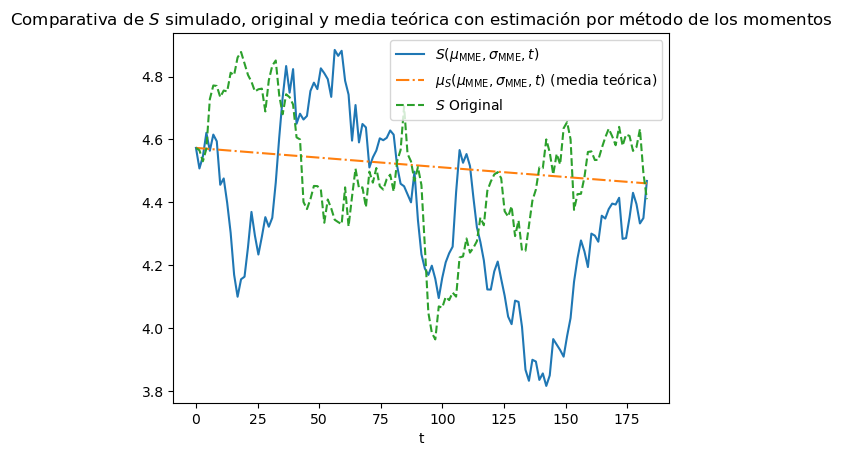

In [26]:
from IPython.display import display, Math
# fijamos la semilla para poder reproducir los mismos resultados
np.random.seed(3440)
# Inicializar los valores
num_steps = len(S)       # Número de pasos en cada simulación (tamaño de S)
delta_t = time_length / num_steps # factor de escala temporal entre dos días de mercado con el objetivo de completar la longitud de la ventana temporal             
# Calcular los retornos logarítmicos
U = np.log(S[1:] / S[:-1])

# Calcular sigma y mu a partir de los retornos logarítmicos
sigmaMME = np.std(U, ddof=1) / np.sqrt(delta_t)
muMME = (np.mean(U) + sigmaMME**2 / 2) / delta_t

# Mostrar estimaciones
texto = f"\\text{{Los estimadores son: }}\\mu_{{\\text{{MME}}}} = {muMME:0.5f} \\text{{ y }} \\sigma_{{\\text{{MME}}}} = {sigmaMME:0.5f}"
display(Math(texto))

# Simular el proceso de Wiener usando operaciones vectorizadas
t = np.linspace(0, num_steps * delta_t, num_steps)  # Vector de tiempo
w_increments = np.sqrt(delta_t) * np.random.normal(0, 1, num_steps - 1)  # Incrementos del proceso de Wiener
w_values = np.insert(np.cumsum(w_increments), 0, 0)  # Proceso de Wiener acumulado, con 0 inicial

# Calcular S(t) usando la fórmula con los valores calculados de mu y sigma
S0 = S[0]  # Valor inicial de S tomado de los datos originales
S_values_MME = S0 * np.exp((muMME - 0.5 * sigmaMME**2) * t + sigmaMME * w_values)

# Calcular la media teórica E(S(t)) = S0 * exp(muMME * t)
mu_S_values_MME = S0 * np.exp(muMME * t)

# Graficar S(t) simulado, los datos originales y la media teórica
plt.plot(t, S_values_MME, label=r'$S\left(\mu_{\text{MME}},\sigma_{\text{MME}},t\right)$')
plt.plot(t, mu_S_values_MME, label=r'$\mu_S\left(\mu_{\text{MME}},\sigma_{\text{MME}},t\right)$ (media teórica)', linestyle='-.')
plt.plot(t, S, label=r'$S$ Original', linestyle='--')

# Configurar título y etiquetas en formato LaTeX
plt.title(r'Comparativa de $S$ simulado, original y media teórica con estimación por método de los momentos')
plt.xlabel(r't')
#plt.ylabel(r'$S(t)$')

# Mostrar leyenda y gráfico
plt.legend()
plt.show()


## Método de Máxima Verosimilitud

<IPython.core.display.Math object>

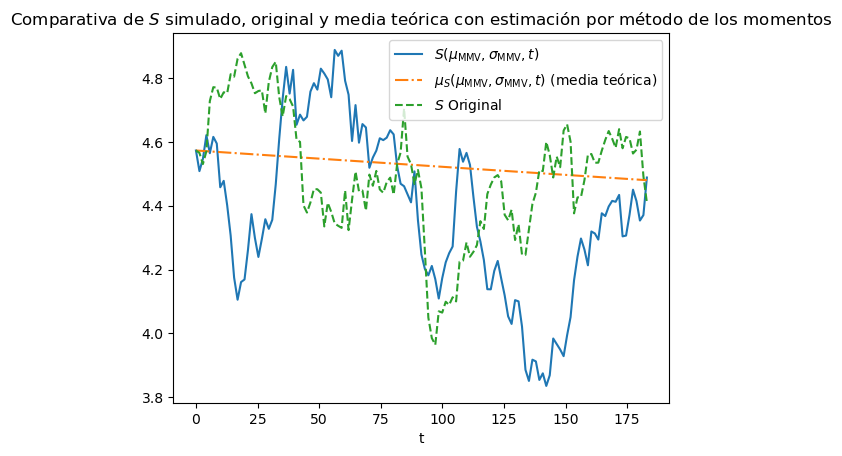

In [27]:
# Calcular los retornos absolutos
R = S[1:] / S[:-1] - 1

# Calcular sigma y mu a partir de los retornos absolutos
sigmaMMV = np.std(R, ddof=0) / np.sqrt(delta_t)
muMMV = np.mean(R) / delta_t

# Mostrar estimaciones
texto = f"\\text{{Los estimadores son: }}\\mu_{{\\text{{MMV}}}} = {muMMV:0.5f} \\text{{ y }} \\sigma_{{\\text{{MMV}}}} = {sigmaMMV:0.5f}"
display(Math(texto))

# Calcular S(t) usando la fórmula con los valores calculados de mu y sigma
S0 = S[0]  # Valor inicial de S tomado de los datos originales
S_values_MMV = S0 * np.exp((muMMV - 0.5 * sigmaMMV**2) * t + sigmaMMV * w_values)

# Calcular la media teórica E(S(t)) = S0 * exp(mu * t)
mu_S_values_MMV = S0 * np.exp(muMMV * t)

# Graficar S(t) simulado, los datos originales y la media teórica
plt.plot(t, S_values_MMV, label=r'$S\left(\mu_{\text{MMV}},\sigma_{\text{MMV}},t\right)$')
plt.plot(t, mu_S_values_MMV, label=r'$\mu_S\left(\mu_{\text{MMV}},\sigma_{\text{MMV}},t\right)$ (media teórica)', linestyle='-.')
plt.plot(t, S, label=r'$S$ Original', linestyle='--')

# Configurar título y etiquetas en formato LaTeX
plt.title(r'Comparativa de $S$ simulado, original y media teórica con estimación por método de los momentos')
plt.xlabel(r't')
#plt.ylabel(r'$S(t)$')

# Mostrar leyenda y gráfico
plt.legend()
plt.show()


## Comparativa entre ambos métodos

Para comparar ambos métodos vamos a ver como se miden respecto al camino real que llevó el precio del subyacente en la ventana de tiempo estudiada.

<IPython.core.display.Math object>

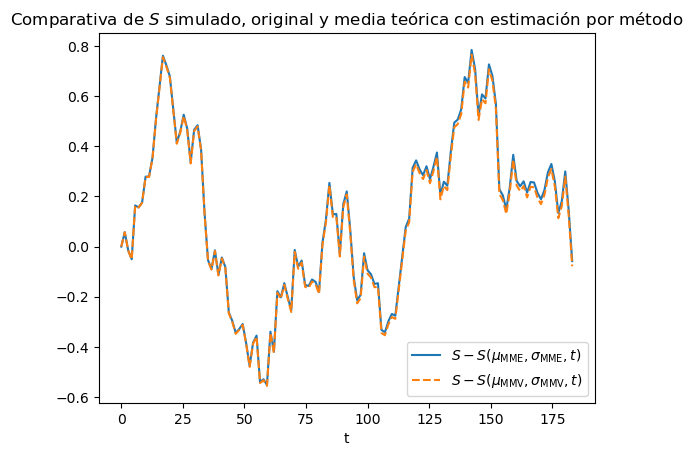

In [28]:
# Graficar S(t) simulado, los datos originales y la media teórica
plt.plot(t, S-S_values_MME, label=r'$S-S\left(\mu_{\text{MME}},\sigma_{\text{MME}},t\right)$', linestyle='-')
plt.plot(t, S-S_values_MMV, label=r'$S-S\left(\mu_{\text{MMV}},\sigma_{\text{MMV}},t\right)$', linestyle= '--')
# Mostrar errores estimaciones
texto =  f"\\text{{Los errores de las estimaciones son: }} \\; |S - S(\\mu_{{\\text{{MME}}}}, \\sigma_{{\\text{{MME}}}}, t)| = {np.linalg.norm(S-S_values_MME):0.5f}, |S - S(\\mu_{{\\text{{MMV}}}}, \\sigma_{{\\text{{MMV}}}}, t)| = {np.linalg.norm(S-S_values_MMV):0.5f}"
display(Math(texto))


# Configurar título y etiquetas en formato LaTeX
plt.title(r'Comparativa de $S$ simulado, original y media teórica con estimación por método')
plt.xlabel(r't')
#plt.ylabel(r'$S(t)$')

# Mostrar leyenda y gráfico
plt.legend()
plt.show()

In [29]:
# Método de momentos
ECM_MME=np.sqrt(np.sum((S-S_values_MME)**2))
EPAM_MME = 100*np.mean(abs(1-S_values_MME/S))

# Método de máxima verosimilitud
ECM_MMV=np.sqrt(np.sum((S-S_values_MMV)**2))
EPAM_MMV = 100*np.mean(abs(1-S_values_MMV/S))

# Resultados
print(f'ECM_MME={ECM_MME:.5f} y EPAMMME(%)={EPAM_MME:.3f}%')
print(f'ECM_MMV={ECM_MMV:.5f} y EPAMMMV(%)={EPAM_MMV:.3f}%')

ECM_MME=3.93468 y EPAMMME(%)=6.352%
ECM_MMV=3.86334 y EPAMMMV(%)=6.245%


Sobre el camino de Wiener estudiado (que es una realización aleatoria cualquiera) rinde mejor el método de máxima verosimilitud, basándonos en los dos indicadores anteriores. Estas conclusiones podrían variar si cambiásemos la realización del camino de Wiener bajo estudio, y lo que está claro es que ambos métodos son cercanos, como no podría ser de otra manera, pues son dos formas distintas de aproximar los mismos estadísticos. 

Además, estamos utilizando un modelo de vola y retornos constantes, que es una aproximación muy sencilla de las dinámicas que se podrían calibrar usando las expectativas de mercado. Nuestra realización se queda lejos del camino real que ha llevado el subyacente en la ventana temporal, pero esto es normal, puesto que nunca vamos a acertar los resultados de un experimento aleatorio aunque conociéramos la distribución real con precisión, de manera que este análisis camino contra camino es más didáctico que otra cosa.

Vamos a hacer el mismo estudio, pero comparando el camino real contra la media teórica bajo las distintas aproximaciones de los parámetros:$$\mathbb{E}(\hat{S}_t)=S_oe^{\hat{\mu}t}$$

<IPython.core.display.Math object>

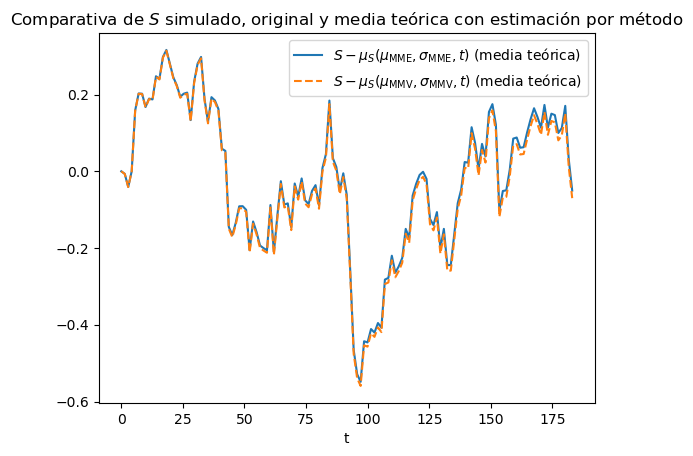

In [35]:
# Graficar S(t) simulado, los datos originales y la media teórica
#plt.plot(t, S_values_MME-S_values_MMV, label=r'$S\left(\mu_{\text{MMV}},\sigma_{\text{MMV}},t\right)$')
plt.plot(t, S-mu_S_values_MME, label=r'$S-\mu_S\left(\mu_{\text{MME}},\sigma_{\text{MME}},t\right)$ (media teórica)', linestyle='-')
plt.plot(t, S-mu_S_values_MMV, label=r'$S-\mu_S\left(\mu_{\text{MMV}},\sigma_{\text{MMV}},t\right)$ (media teórica)', linestyle='--')

# Mostrar errores estimaciones
texto =  f"\\text{{Los errores de las estimaciones son: }} \\; |S - \\mu_S(\\mu_{{\\text{{MME}}}}, \\sigma_{{\\text{{MME}}}}, t)| = {np.linalg.norm(S-mu_S_values_MME):0.5f}, |S - \\mu_S(\\mu_{{\\text{{MMV}}}}, \\sigma_{{\\text{{MMV}}}}, t)| = {np.linalg.norm(S-mu_S_values_MMV):0.5f}"
display(Math(texto))

# Configurar título y etiquetas en formato LaTeX
plt.title(r'Comparativa de $S$ simulado, original y media teórica con estimación por método')
plt.xlabel(r't')
#plt.ylabel(r'$S(t)$')

# Mostrar leyenda y gráfico
plt.legend()
plt.show()

In [34]:
# Método de momentos
ECM_MME_mu=np.sqrt(np.sum((S-mu_S_values_MME)**2))
EPAM_MME_mu = 100*np.mean(abs(1-mu_S_values_MME/S))

# Método de máxima verosimilitud
ECM_MMV_mu=np.sqrt(np.sum((S-mu_S_values_MMV)**2))
EPAM_MMV_mu = 100*np.mean(abs(1-mu_S_values_MMV/S))

# Resultados
print(f'ECM_MME_mu={ECM_MME_mu:.5f} y EPAMMME(%)={EPAM_MME_mu:.3f}%')
print(f'ECM_MMV_mu={ECM_MMV_mu:.5f} y EPAMMMV(%)={EPAM_MMV_mu:.3f}%')

ECM_MME_mu=2.16760 y EPAMMME(%)=3.407%
ECM_MMV_mu=2.19543 y EPAMMMV(%)=3.438%


Ahora, al contrario que con la comparación del camino real frente al simulado bajo una realización del proceso de Wiener, comparando en esta ocasión el valor esperado del activo contra el valor real en cada instante temporal para cada par de (media, varianza) calibrados anteriormente, vemos que rinde mejor el método de momentos teóricos que el de máxima verosimilitud (atendiendo únicamente a las métricas anteriores). De nuevo, estas conclusiones no son muy definitivas, puesto que no se puede juzgar la calidad de un modelo aleatorio por lo alejado que sea un resultado del mismo respecto de la media.